Setup


In [47]:
# === Cell 0: Imports ===
import os, re, glob
from pathlib import Path
import numpy as np
import pandas as pd
import soundfile as sf
import librosa
import matplotlib.pyplot as plt
from numpy.fft import rfft, rfftfreq

print("Ready!")


Ready!


1. Analysis Parameters


In [48]:
# === Cell 1: Tunable parameters ===
SR        = 48000            # analysis sample rate
F0        = 1000.0           # test tone (Hz)
NFFT_MAIN = 65536            # FFT size (tone/silence spectra)
BAND_HZ   = 5.0              # ±Hz around f0/harmonics to integrate power
TRIM_SEC  = 1.0              # cut head+tail (avoid transients)
MAX_H     = 10               # up to 10th harmonic

# Short-time SNR (per-frame)
ST_FRAME  = int(0.050*SR)    # 50 ms
ST_HOP    = int(0.025*SR)    # 25 ms
NFFT_ST   = 16384

DATA_ROOT = Path("data")     # Step-1 output folder
PLOTS_DIR = Path("plots_step2"); PLOTS_DIR.mkdir(parents=True, exist_ok=True)


2. Helper Functions


In [49]:
# === Cell 2: Helpers (load, FFT, metrics, scoring) ===
def load_wav_center(path, sr=SR, trim_sec=TRIM_SEC):
    """Mono, resample to SR, remove DC, keep steady middle (trim head/tail)."""
    y, srx = sf.read(path, dtype='float32')
    if y.ndim > 1: y = y.mean(axis=1)
    if srx != sr:
        y = librosa.resample(y, orig_sr=srx, target_sr=sr)
    if len(y) > 2*int(trim_sec*sr):
        y = y[int(trim_sec*sr):-int(trim_sec*sr)]
    y = y - np.mean(y)
    return y, sr

def mag_spectrum(y, sr=SR, nfft=NFFT_MAIN, use_hann=True):
    """Single-sided magnitude spectrum (Hann window + amplitude normalization)."""
    y = y.astype(np.float64)
    if use_hann:
        w = np.hanning(len(y)); y = y * w
        norm = (np.sum(w)/2.0)
    else:
        norm = len(y)/2.0
    if len(y) < nfft:
        y = np.pad(y, (0, nfft-len(y)))
    Y = rfft(y[:nfft])
    mag = np.abs(Y) / (norm if norm>0 else 1.0)
    freqs = rfftfreq(nfft, 1/sr)
    return freqs, mag

def band_power(freqs, mag, f_center, width_hz=BAND_HZ):
    sel = (freqs >= f_center-width_hz) & (freqs <= f_center+width_hz)
    return float(np.sum(mag[sel]**2))

def analyze_tone(tone_path):
    """Return dict with f0, SNR(dB), THD(%), THD+N(dB) + spectra & time."""
    y, sr = load_wav_center(tone_path, SR)
    freqs, mag = mag_spectrum(y, sr)
    sel = (freqs >= F0-BAND_HZ) & (freqs <= F0+BAND_HZ)
    if not np.any(sel): return None
    f0_est = freqs[sel][np.argmax(mag[sel])]
    P1 = band_power(freqs, mag, f0_est)
    Ph = 0.0
    for h in range(2, MAX_H+1):
        fc = h*f0_est
        if fc >= freqs[-1]: break
        Ph += band_power(freqs, mag, fc)
    Ptot = float(np.sum(mag**2))
    Pn = max(Ptot - P1 - Ph, 1e-20)
    SNR_dB  = 10*np.log10(P1/Pn)
    THD_pct = 100*np.sqrt(Ph/P1) if P1>0 else np.nan
    THDN_dB = 10*np.log10((Ph+Pn)/P1) if P1>0 else np.nan
    return dict(f0=f0_est, SNR_dB=SNR_dB, THD_pct=THD_pct, THDN_dB=THDN_dB,
                freqs=freqs, mag=mag, y=y)

def analyze_silence(sil_path):
    """Return dict with noise_floor_dbfs + spectra & time."""
    y, sr = load_wav_center(sil_path, SR)
    freqs, mag = mag_spectrum(y, sr)
    noise_floor_dbfs = 20*np.log10(np.median(mag)+1e-20)
    return dict(noise_floor_dbfs=noise_floor_dbfs, freqs=freqs, mag=mag, y=y)

# scoring: map raw metrics to 0–100 and combine
def _lin(x, x0, x1):
    if x <= x0: return 0.0
    if x >= x1: return 100.0
    return 100.0*(x-x0)/(x1-x0)

def score_metrics(SNR_dB, THD_pct, THDN_dB, noise_floor_dbfs, weights=(1,1.2,1.2,1)):
    snr_s = _lin(SNR_dB,      40, 70)     # higher better
    thd_s = _lin(-THD_pct,    -2, -0.1)   # lower % better
    thn_s = _lin(-THDN_dB,    30, 60)     # more negative better
    nff_s = _lin(-noise_floor_dbfs, 55, 80)
    w = np.array(weights, float); w /= w.sum()
    final = w.dot([snr_s, thd_s, thn_s, nff_s])
    return snr_s, thd_s, thn_s, nff_s, final


3. Scan data/ and pair tone/silence


In [50]:
# === Cell 3: Read file list ===
pattern = re.compile(
    r"(?P<mic>Mic[A-Za-z0-9]+)_dist(?P<dist>\d+)cm_ang(?P<ang>\d+)_"
    r"(?P<kind>tone|silence)_rep(?P<rep>\d+)\.wav$"
)

rows = []
for mic_dir in sorted(glob.glob(str(DATA_ROOT / "Mic*"))):
    for wav in sorted(glob.glob(os.path.join(mic_dir, "*.wav"))):
        m = pattern.search(os.path.basename(wav))
        if m:
            d = m.groupdict(); d["path"] = wav
            rows.append(d)

df = pd.DataFrame(rows)
if df.empty:
    raise SystemExit("No files found in ./data — run Step-1 generator first.")
df.head()


,mic,dist,ang,kind,rep,path
0,MicA,20,0,silence,1,data\MicA\MicA_dist20cm_ang0_silence_rep1.wav
1,MicA,20,0,silence,2,data\MicA\MicA_dist20cm_ang0_silence_rep2.wav
2,MicA,20,0,tone,1,data\MicA\MicA_dist20cm_ang0_tone_rep1.wav
3,MicA,20,0,tone,2,data\MicA\MicA_dist20cm_ang0_tone_rep2.wav
4,MicA,20,45,silence,1,data\MicA\MicA_dist20cm_ang45_silence_rep1.wav


4. Per-condition analysis → metrics + time/frequency plots


In [51]:
# === Cell 4: Compute metrics per (mic, distance, angle, repeat) ===
per_records = []

for (mic, dist, ang, rep), g in df.groupby(["mic","dist","ang","rep"]):
    paths = {r["kind"]: r["path"] for _, r in g.iterrows()}
    if "tone" not in paths or "silence" not in paths: 
        continue

    tone = analyze_tone(paths["tone"])
    sil  = analyze_silence(paths["silence"])
    if tone is None or sil is None: 
        continue

    # scores
    s_snr, s_thd, s_thdn, s_nf, s_final = score_metrics(
        tone["SNR_dB"], tone["THD_pct"], tone["THDN_dB"], sil["noise_floor_dbfs"],
        weights=(1,1.2,1.2,1)
    )

    # store
    per_records.append(dict(
        mic=mic, dist_cm=int(dist), angle_deg=int(ang), rep=int(rep),
        f0_est=tone["f0"],
        SNR_dB=tone["SNR_dB"], THD_pct=tone["THD_pct"], THD_N_dB=tone["THDN_dB"],
        noise_floor_dbfs=sil["noise_floor_dbfs"],
        score_snr=s_snr, score_thd=s_thd, score_thdn=s_thdn, score_nf=s_nf,
        score_final=s_final,
        tone_path=paths["tone"], silence_path=paths["silence"],
        tone_y=tone["y"], tone_freqs=tone["freqs"], tone_mag=tone["mag"],
        sil_y=sil["y"], sil_freqs=sil["freqs"], sil_mag=sil["mag"]
    ))

res = pd.DataFrame(per_records).sort_values(["mic","dist_cm","angle_deg","rep"])
res.head()


,mic,dist_cm,angle_deg,rep,f0_est,SNR_dB,THD_pct,THD_N_dB,noise_floor_dbfs,score_snr,...,score_nf,score_final,tone_path,silence_path,tone_y,tone_freqs,tone_mag,sil_y,sil_freqs,sil_mag
0,MicA,20,0,1,999.755859,12.891502,1.528980,-12.871789,-111.079766,0.0,...,100.0,29.488323,data\MicA\MicA_dist20cm_ang0_tone_rep1.wav,data\MicA\MicA_dist20cm_ang0_silence_rep1.wav,"[-0.0033666904, 0.01930787, 0.051412363, 0.069...","[0.0, 0.732421875, 1.46484375, 2.197265625, 2....","[5.429643509015305e-06, 1.116045295622159e-05,...","[-0.008157873, -0.0064183706, 0.015340663, -0....","[0.0, 0.732421875, 1.46484375, 2.197265625, 2....","[2.4350708935121318e-06, 2.872512525503105e-06..."
1,MicA,20,0,2,999.755859,12.964622,1.744288,-12.938549,-111.550942,0.0,...,100.0,26.397783,data\MicA\MicA_dist20cm_ang0_tone_rep2.wav,data\MicA\MicA_dist20cm_ang0_silence_rep2.wav,"[-0.0077733435, 0.057381686, 0.0641871, 0.0959...","[0.0, 0.732421875, 1.46484375, 2.197265625, 2....","[1.0210669424949032e-05, 1.4227000195734011e-0...","[-0.0022155282, -0.018298293, -0.0022460457, -...","[0.0, 0.732421875, 1.46484375, 2.197265625, 2....","[4.096065215475015e-06, 5.075925667180979e-06,..."
2,MicA,20,45,1,999.755859,12.977953,1.225448,-12.965026,-107.703355,0.0,...,100.0,33.845240,data\MicA\MicA_dist20cm_ang45_tone_rep1.wav,data\MicA\MicA_dist20cm_ang45_silence_rep1.wav,"[-0.0051898966, 0.052640915, 0.034391403, 0.05...","[0.0, 0.732421875, 1.46484375, 2.197265625, 2....","[5.189664697515106e-06, 4.775767304189581e-06,...","[-0.037167676, 0.043215625, -0.012356883, 0.01...","[0.0, 0.732421875, 1.46484375, 2.197265625, 2....","[4.7536764304762555e-06, 3.4694331064943714e-0..."
3,MicA,20,45,2,999.755859,11.971687,2.032443,-11.943530,-112.771946,0.0,...,100.0,22.727273,data\MicA\MicA_dist20cm_ang45_tone_rep2.wav,data\MicA\MicA_dist20cm_ang45_silence_rep2.wav,"[-0.015822435, 0.039963696, 0.03926179, 0.0985...","[0.0, 0.732421875, 1.46484375, 2.197265625, 2....","[2.2921472146201896e-05, 1.3220405955223498e-0...","[0.000645876, 0.010716677, 0.006932497, -0.004...","[0.0, 0.732421875, 1.46484375, 2.197265625, 2....","[1.1840282003219225e-06, 6.832752465836553e-07..."
4,MicA,50,0,1,999.755859,6.971547,2.225036,-6.960855,-104.624571,0.0,...,100.0,22.727273,data\MicA\MicA_dist50cm_ang0_tone_rep1.wav,data\MicA\MicA_dist50cm_ang0_silence_rep1.wav,"[0.0077104927, 0.025471723, 0.02223686, 0.0158...","[0.0, 0.732421875, 1.46484375, 2.197265625, 2....","[1.0342683118174229e-05, 1.198923452549546e-05...","[-0.0059760516, 0.01151052, -0.010309548, -0.0...","[0.0, 0.732421875, 1.46484375, 2.197265625, 2....","[2.486109378934898e-06, 7.34690572320207e-06, ..."


5. Plotting helpers (time & frequency; THD bars; short-time SNR)


In [52]:
# === Cell 5: Plotting utilities (one chart per figure) ===
def plot_time(y, sr, title, seconds=0.02, save=None):
    N = min(len(y), int(seconds*sr))
    t = np.arange(N)/sr
    plt.figure(figsize=(9,3.5))
    plt.plot(t, y[:N])
    plt.xlabel("Time (s)"); plt.ylabel("Amplitude"); plt.title(title)
    plt.tight_layout()
    if save: plt.savefig(save, dpi=150)
    plt.show()

def plot_spectrum(freqs, mag, f0, title, save=None):
    plt.figure(figsize=(9,3.5))
    plt.semilogx(freqs, 20*np.log10(mag+1e-20))
    for h in range(1, 8):
        fc = h*f0
        if fc >= freqs[-1]: break
        plt.axvline(fc, linestyle='--', alpha=0.6)
    plt.xlabel("Frequency (Hz)"); plt.ylabel("Magnitude (dBFS approx)")
    plt.title(title); plt.grid(True, which='both'); plt.tight_layout()
    if save: plt.savefig(save, dpi=150)
    plt.show()

def plot_thd_bars(freqs, mag, f0, title, save=None):
    P1 = band_power(freqs, mag, f0, BAND_HZ)
    orders, contrib = [], []
    for h in range(2, 11):
        fc = h*f0
        if fc >= freqs[-1]: break
        Ph_h = band_power(freqs, mag, fc, BAND_HZ)
        orders.append(h)
        contrib.append(100*np.sqrt(Ph_h/P1))
    plt.figure(figsize=(9,3.5))
    plt.bar([str(h) for h in orders], contrib)
    plt.xlabel("Harmonic Order"); plt.ylabel("Per-Order THD Contribution (%)")
    plt.title(title); plt.tight_layout()
    if save: plt.savefig(save, dpi=150)
    plt.show()

def plot_short_time_snr(y, title, save=None):
    snr_t, snr_val = [], []
    i = 0
    while i + ST_FRAME <= len(y):
        yfr = y[i:i+ST_FRAME]
        freqs, mag = mag_spectrum(yfr, SR, nfft=NFFT_ST, use_hann=True)
        # local f0
        sel = (freqs>=F0-BAND_HZ) & (freqs<=F0+BAND_HZ)
        f0_fr = freqs[sel][np.argmax(mag[sel])] if np.any(sel) else F0
        P1 = band_power(freqs, mag, f0_fr, BAND_HZ)
        Ph = 0.0
        for h in range(2, 9):
            fc = h*f0_fr
            if fc >= freqs[-1]: break
            Ph += band_power(freqs, mag, fc, BAND_HZ)
        Ptot = float(np.sum(mag**2))
        Pn = max(Ptot - P1 - Ph, 1e-20)
        snr_val.append(10*np.log10(P1/Pn) if P1>0 else np.nan)
        snr_t.append((i + i+ST_FRAME)/(2*SR))
        i += ST_HOP

    plt.figure(figsize=(9,3.5))
    plt.plot(snr_t, snr_val)
    plt.xlabel("Time (s)"); plt.ylabel("Short-time SNR (dB)")
    plt.title(title); plt.tight_layout()
    if save: plt.savefig(save, dpi=150)
    plt.show()


6. Make example plots for a small subset (per mic 2 conditions)


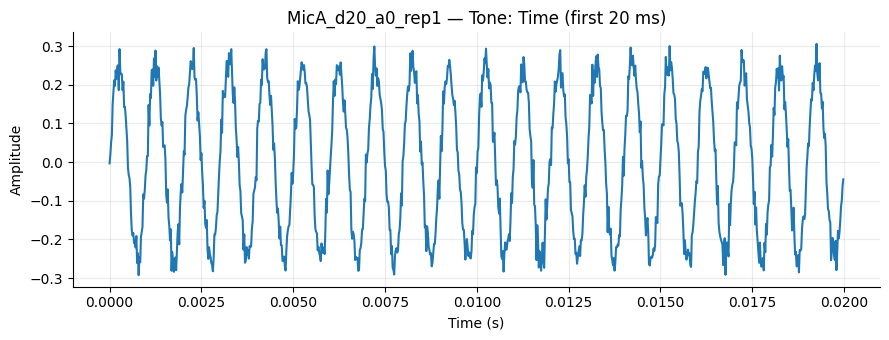

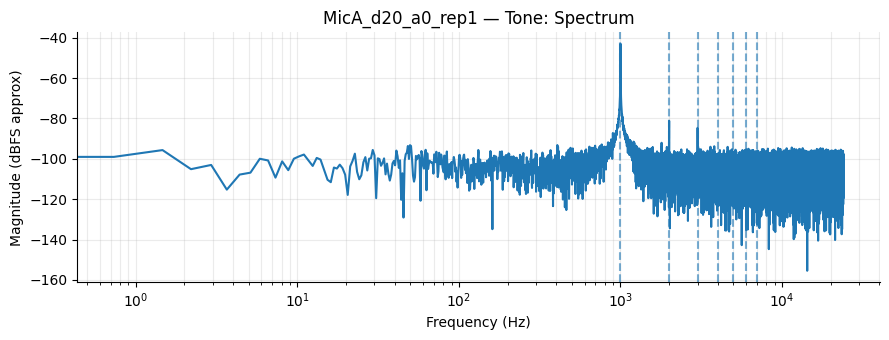

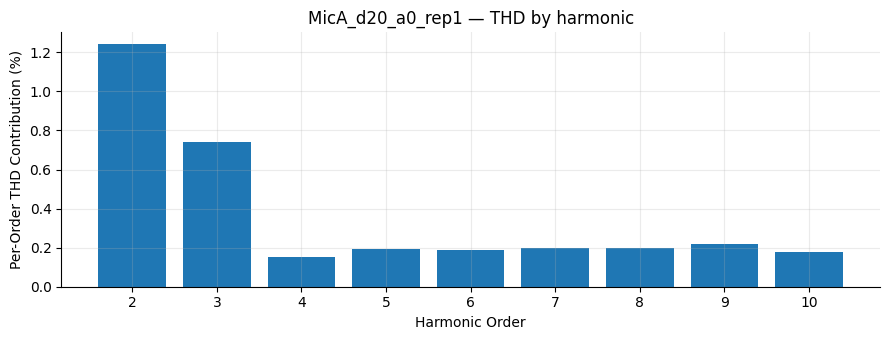

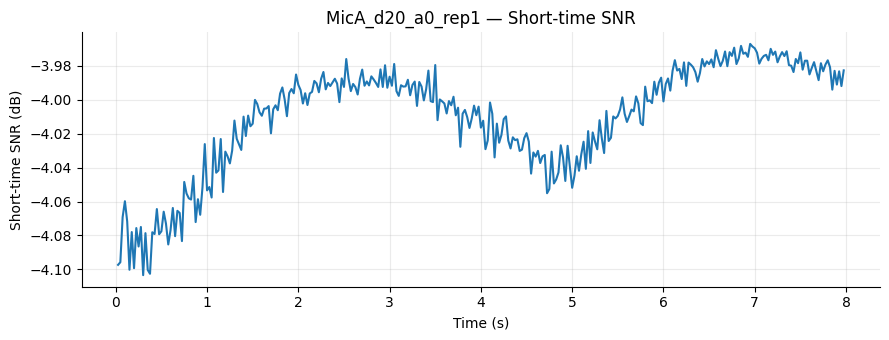

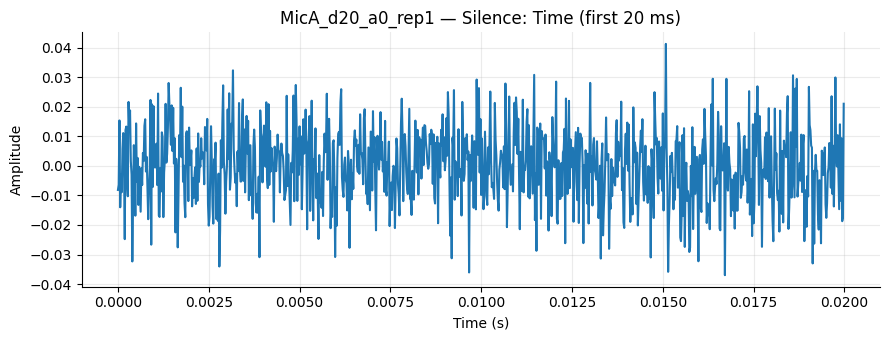

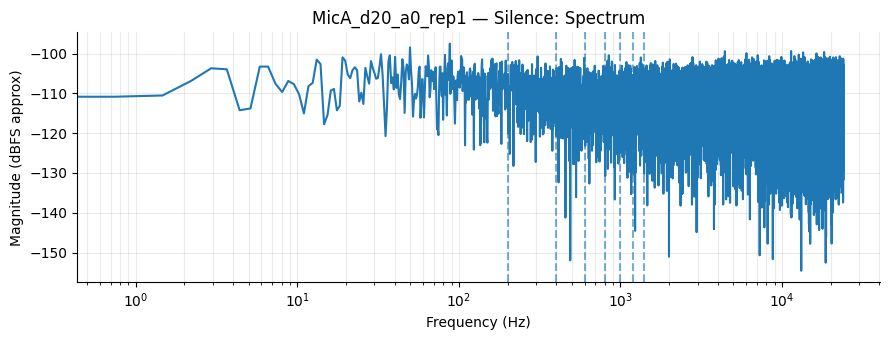

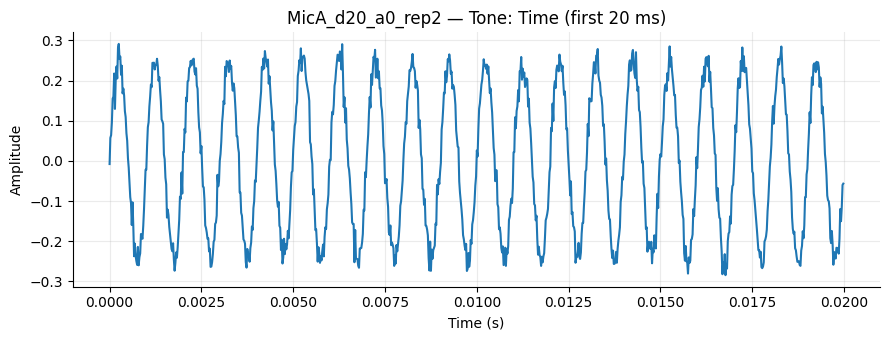

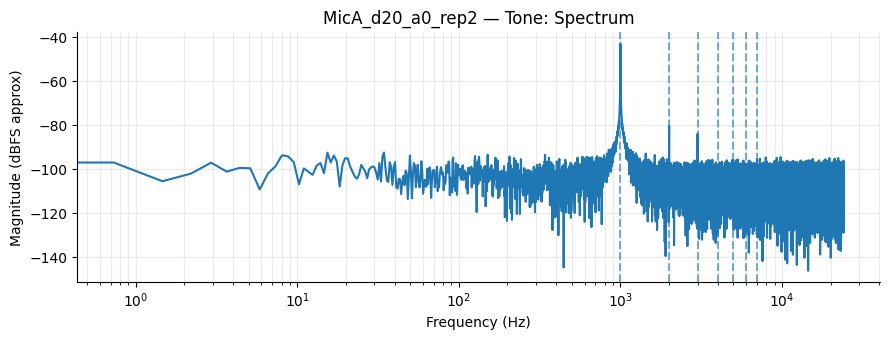

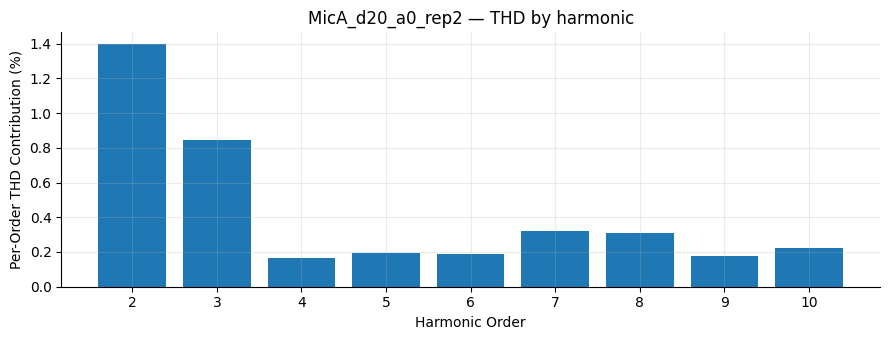

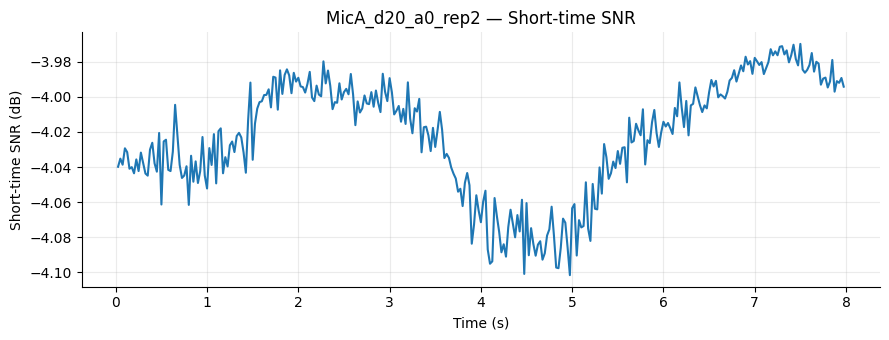

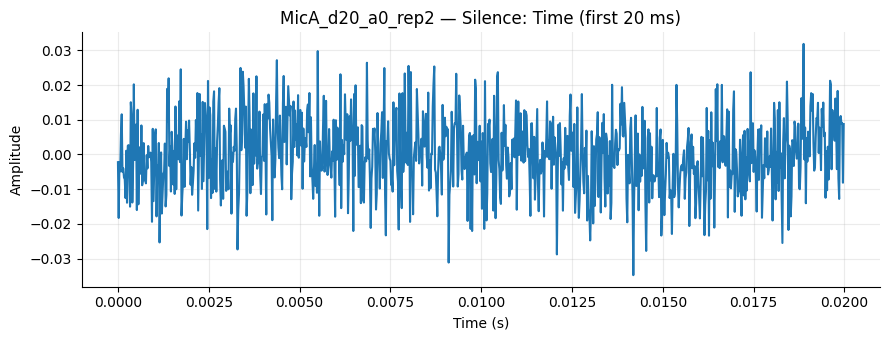

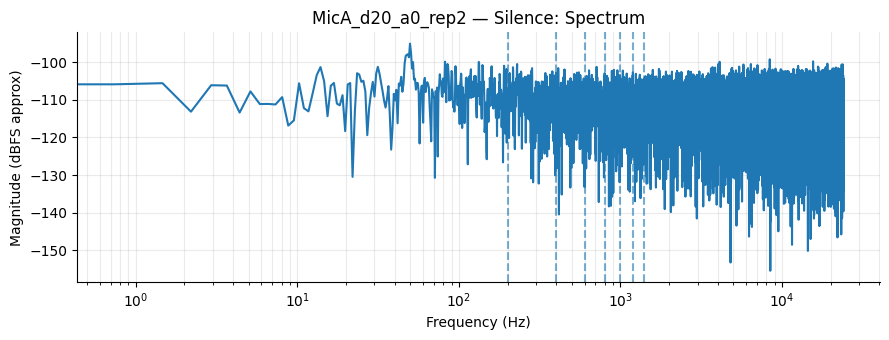

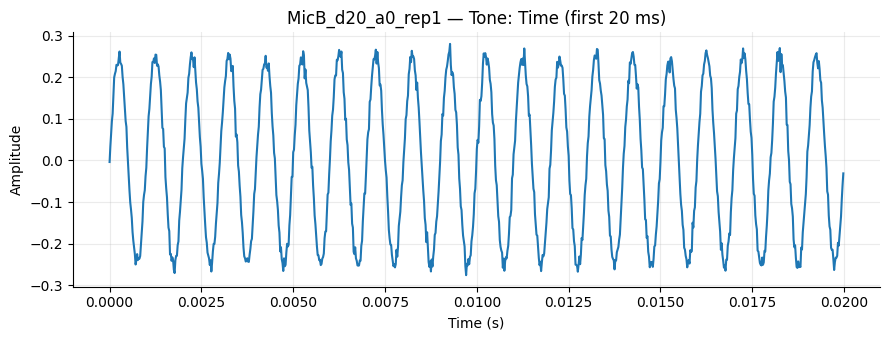

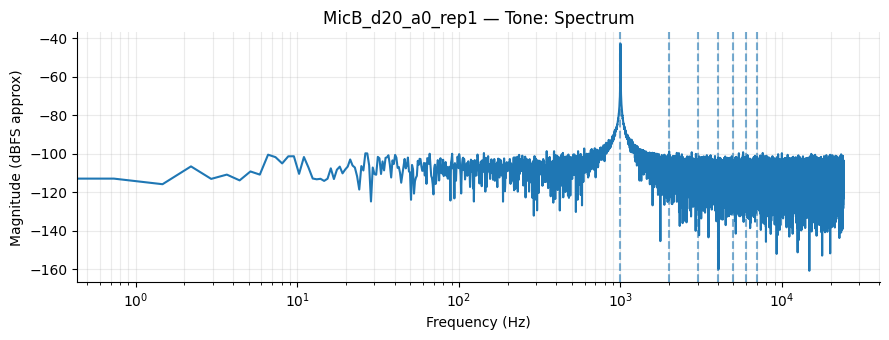

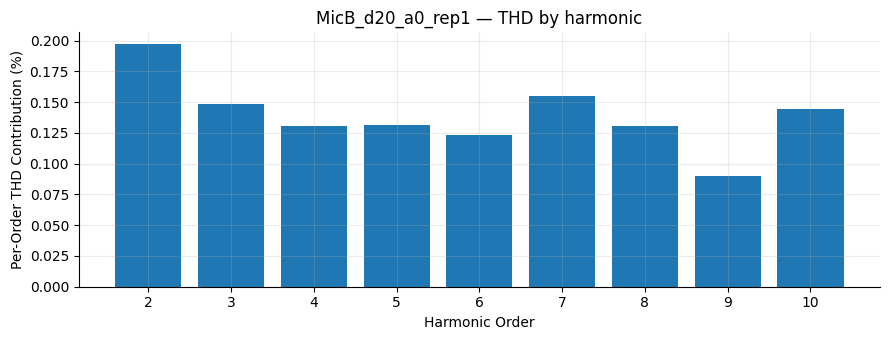

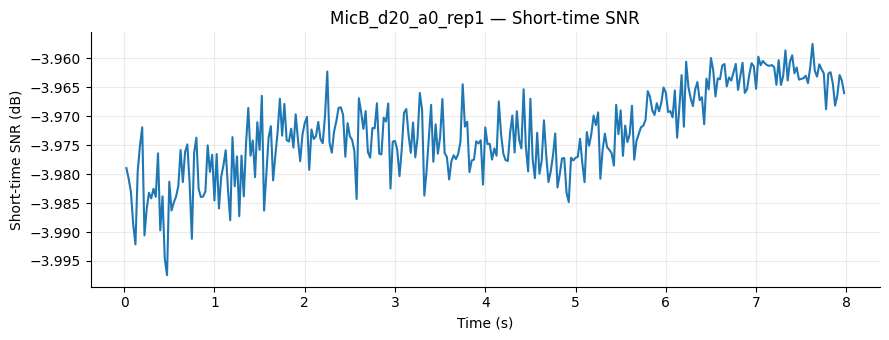

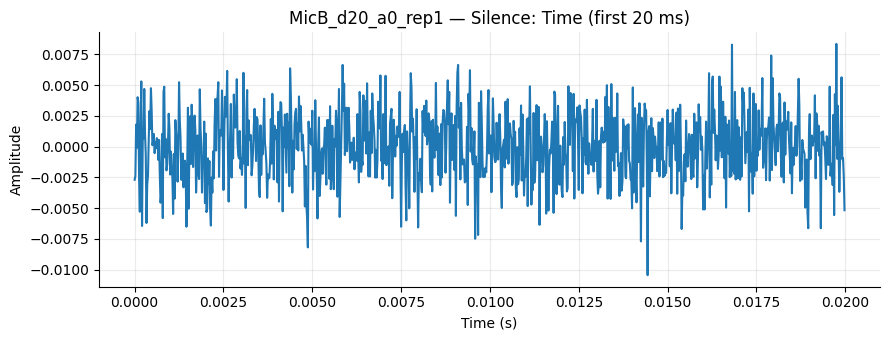

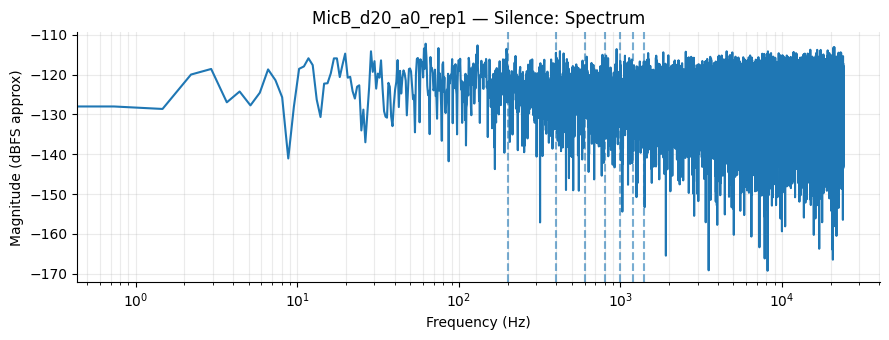

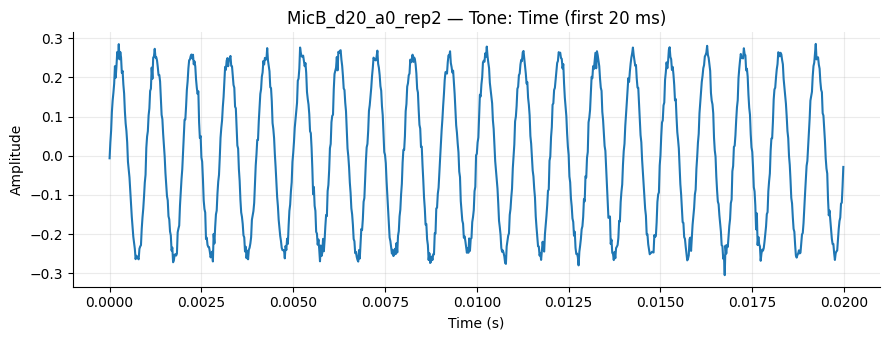

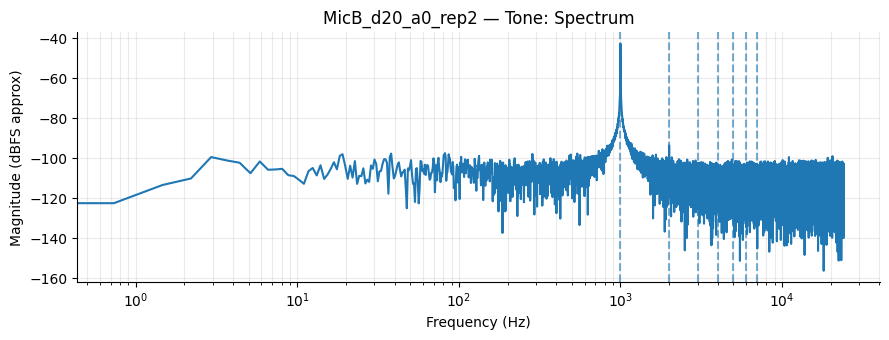

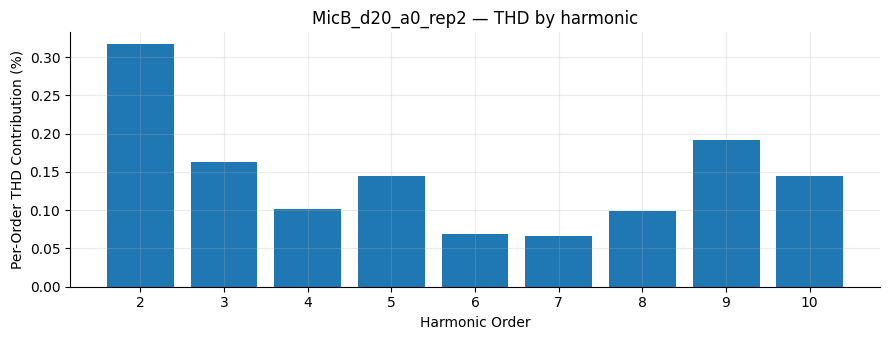

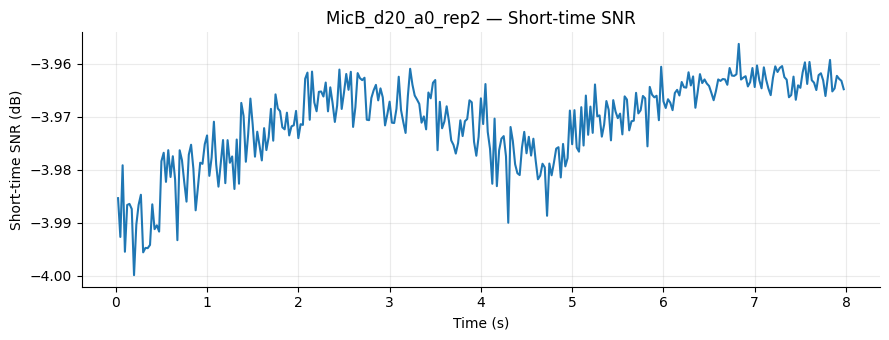

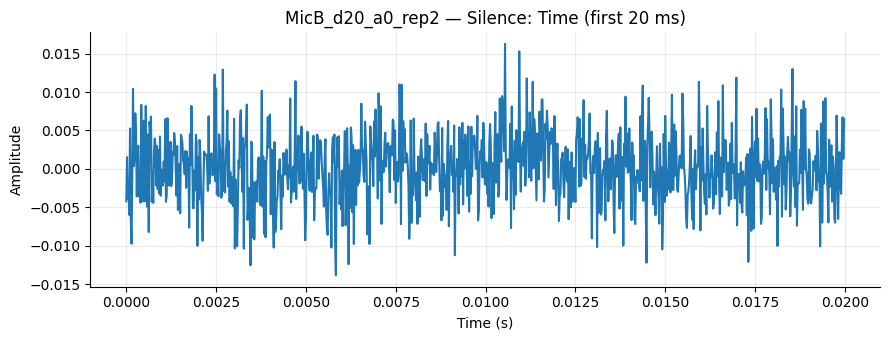

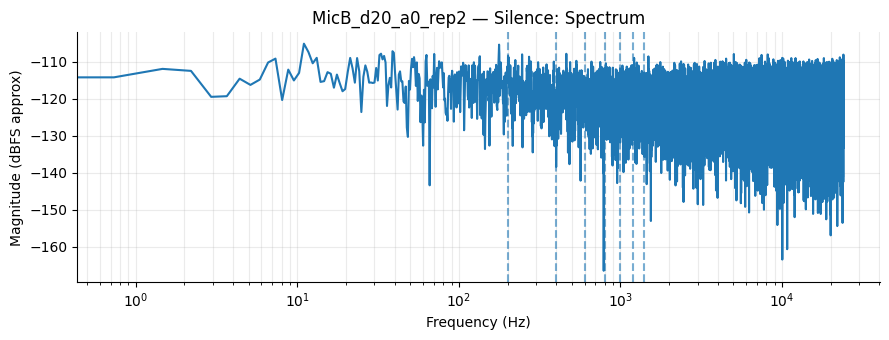

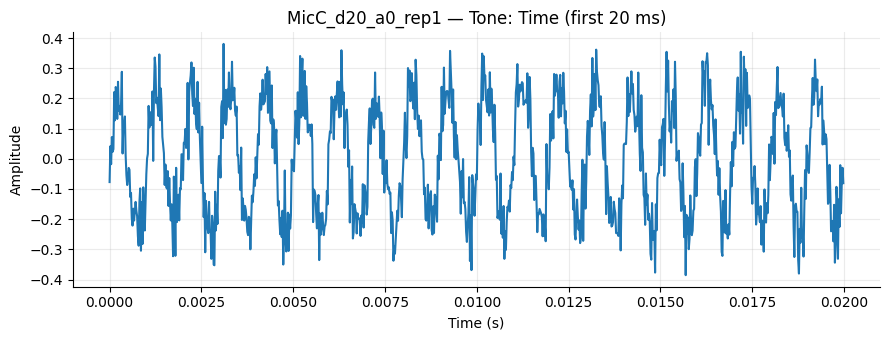

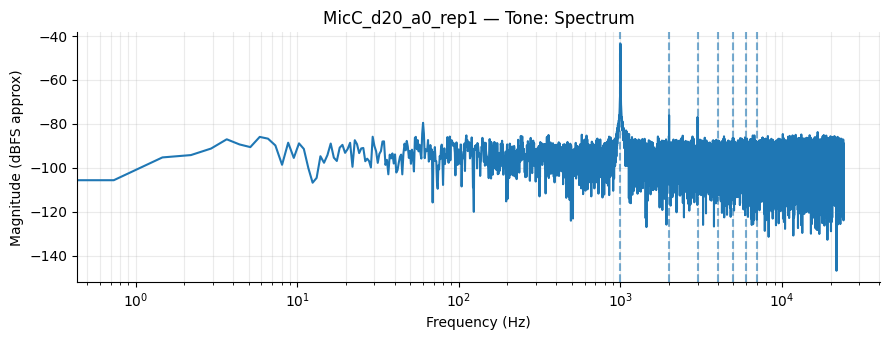

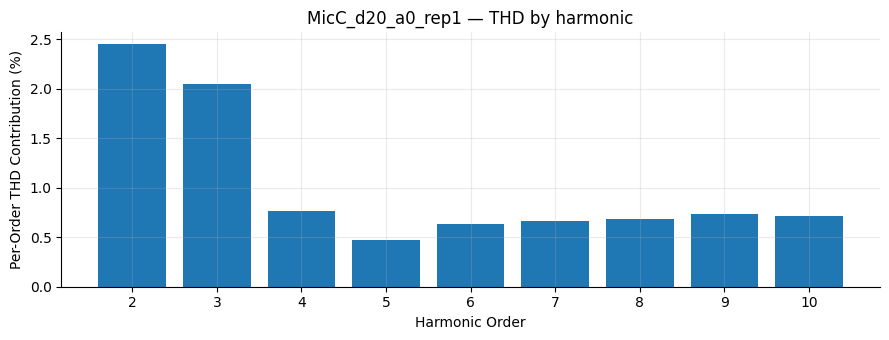

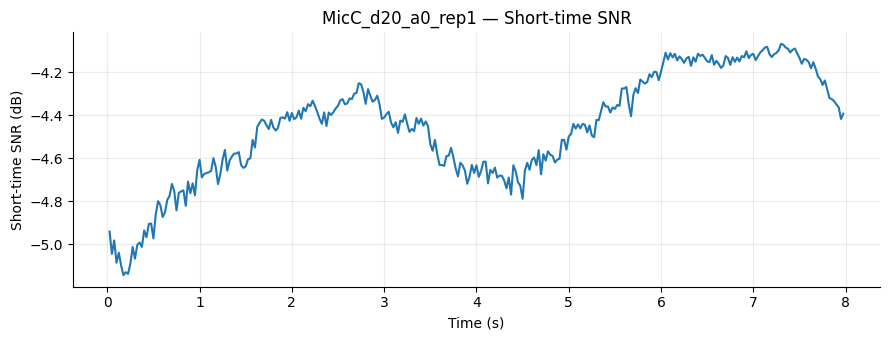

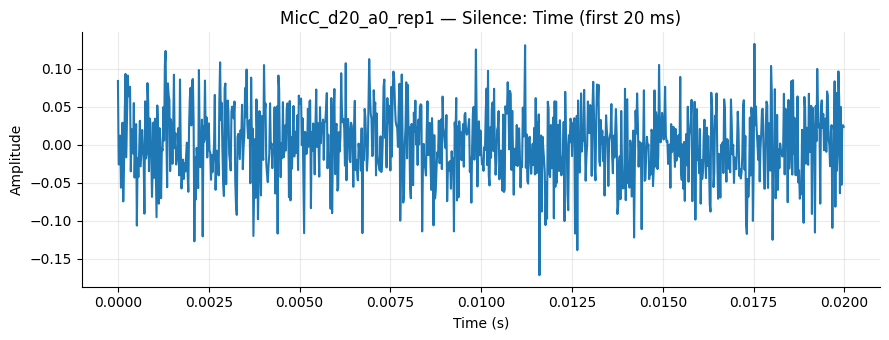

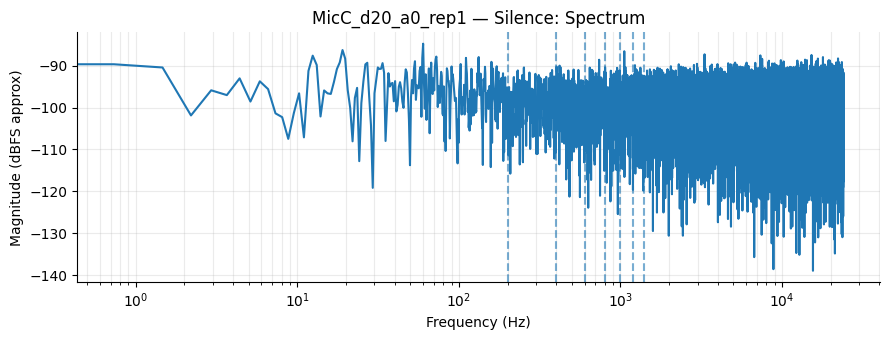

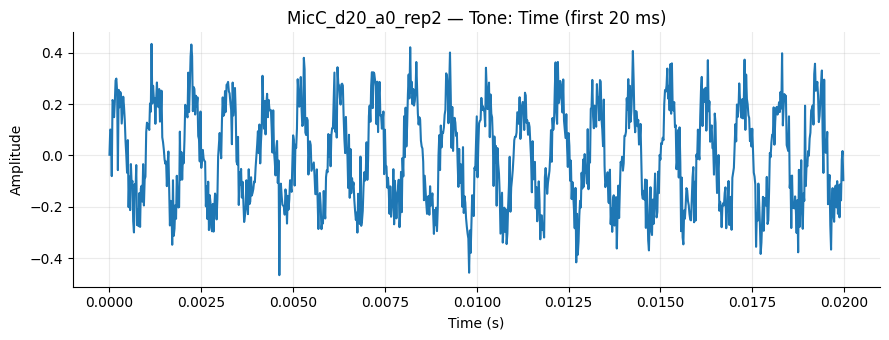

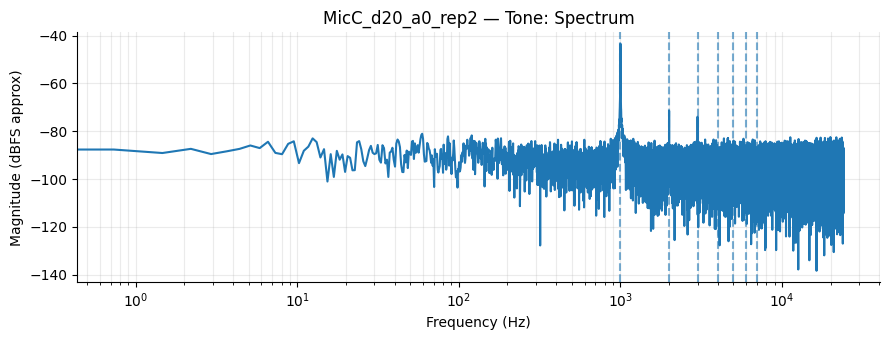

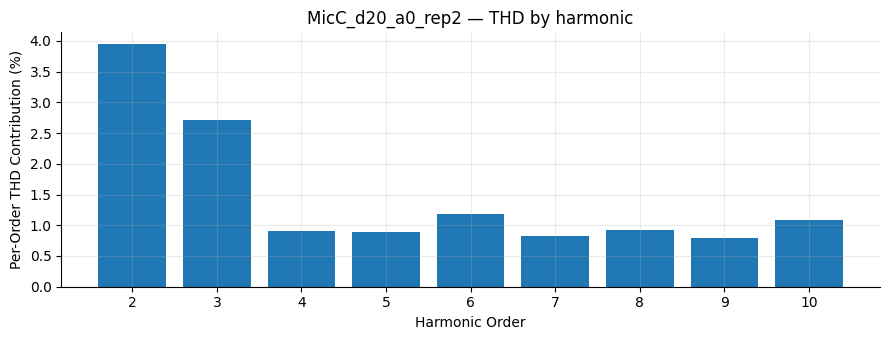

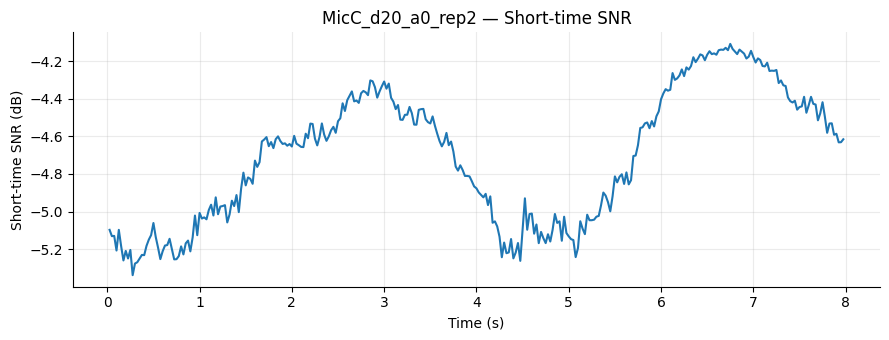

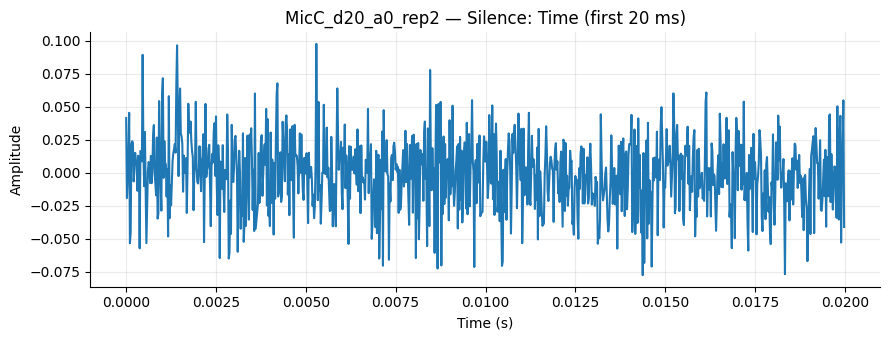

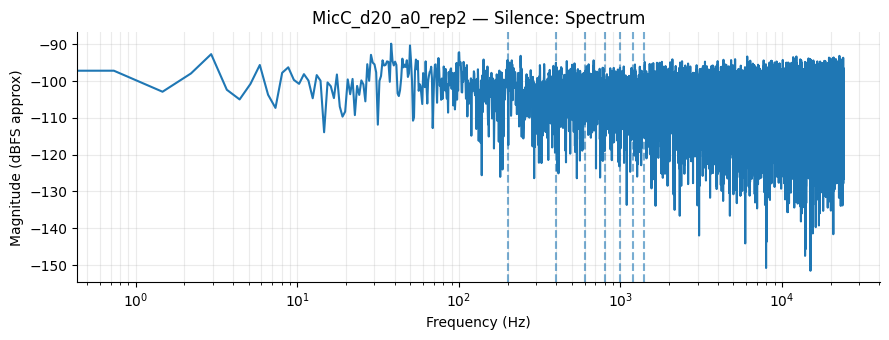

In [53]:
# === Cell 6: Example plots saved into plots_step2/ ===
subset = res.groupby("mic").head(2)
for _, r in subset.iterrows():
    base = f"{r['mic']}_d{r['dist_cm']}_a{r['angle_deg']}_rep{r['rep']}"
    # tone
    plot_time(r["tone_y"], SR, f"{base} — Tone: Time (first 20 ms)",
              save=PLOTS_DIR/f"{base}_tone_time.png")
    plot_spectrum(r["tone_freqs"], r["tone_mag"], r["f0_est"],
                  f"{base} — Tone: Spectrum",
                  save=PLOTS_DIR/f"{base}_tone_spectrum.png")
    plot_thd_bars(r["tone_freqs"], r["tone_mag"], r["f0_est"],
                  f"{base} — THD by harmonic",
                  save=PLOTS_DIR/f"{base}_thd_bars.png")
    plot_short_time_snr(r["tone_y"], f"{base} — Short-time SNR",
                        save=PLOTS_DIR/f"{base}_short_snr.png")
    # silence
    plot_time(r["sil_y"], SR, f"{base} — Silence: Time (first 20 ms)",
              save=PLOTS_DIR/f"{base}_sil_time.png")
    plot_spectrum(r["sil_freqs"], r["sil_mag"], 200.0,
                  f"{base} — Silence: Spectrum",
                  save=PLOTS_DIR/f"{base}_sil_spectrum.png")


7. Save per-condition metrics (CSV)


In [54]:
# === Cell 7: Save detailed results ===
out1 = Path("per_condition_results.csv")
res_to_save = res.drop(columns=["tone_y","tone_freqs","tone_mag","sil_y","sil_freqs","sil_mag"])
res_to_save.to_csv(out1, index=False)
out1


WindowsPath('per_condition_results.csv')

8. Aggregate & rank microphones


In [55]:
# === Cell 8: Ranking ===
agg = (res_to_save.groupby("mic")
       .agg(SNR_dB_mean=("SNR_dB","mean"),
            THD_pct_mean=("THD_pct","mean"),
            THD_N_dB_mean=("THD_N_dB","mean"),
            NoiseFloor_dbfs_mean=("noise_floor_dbfs","mean"),
            Score_final_mean=("score_final","mean"),
            Score_final_std=("score_final","std"),
            N=("score_final","count"))
       .reset_index()
       .sort_values("Score_final_mean", ascending=False))

out2 = Path("mic_ranking.csv")
agg.to_csv(out2, index=False)
agg


,mic,SNR_dB_mean,THD_pct_mean,THD_N_dB_mean,NoiseFloor_dbfs_mean,Score_final_mean,Score_final_std,N
1,MicB,13.126640,0.613958,-13.123316,-120.324896,42.622612,3.390385,8
0,MicA,10.312767,2.093408,-10.292645,-109.232830,25.420964,4.221474,8
2,MicC,3.818175,5.830738,-3.781292,-101.027929,22.727273,0.000000,8


<h1>Plotting</h1>


Cell 0 — Imports & folders


In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

plt.rcParams.update({
    "figure.figsize": (11, 4.5),
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.grid": True,
    "grid.alpha": 0.25
})

df = pd.read_csv("per_condition_results.csv")

# condition label like: "20cm, 0°"
df["cond"] = df["dist_cm"].astype(str) + "cm, " + df["angle_deg"].astype(str) + "°"
cond_order = (df[["dist_cm","angle_deg","cond"]]
              .drop_duplicates()
              .sort_values(["dist_cm","angle_deg"]))["cond"].tolist()

# mean ± std over repeats for each (cond, mic)
mean = (df.groupby(["cond","mic"]).mean(numeric_only=True)
          .reindex(pd.MultiIndex.from_product([cond_order,
                                              sorted(df["mic"].unique())])))
std  = (df.groupby(["cond","mic"]).std(numeric_only=True)
          .reindex(mean.index))

mics = ["MicA","MicB","MicC"]  # fixed order
colors = {"MicA":"#e15759",    # red-ish
          "MicB":"#4e79a7",    # blue
          "MicC":"#f28e2b"}    # orange

outdir = Path("plots_grouped_clean"); outdir.mkdir(parents=True, exist_ok=True)


Cell 1 — Load results & aggregate (mean±std for each condition)


In [62]:
# ---- Typography & color spec ----
TITLE_FONTSIZE = 20       # Title: 20 pt
AXIS_FONTSIZE  = 14       # Axis labels: 14 pt
TICK_FONTSIZE  = 12       # Tick labels: 12 pt
TITLE_LABEL_COLOR = "#4d4b47"   # for title and axis labels

def grouped_bars(metric_key, ylabel, title,
                 invert_for_plot=False,
                 show_unit="",
                 ylim=None,
                 save_as=None,
                 loc="upper right"):
    """
    Grouped bar figure with fixed typography & colors:
      - Title: 20 pt, Bold, color #4d4b47
      - Axis labels: 14 pt, Bold, color #4d4b47
      - Tick labels: 12 pt, Normal
      - Legend: vertical, top-right
      - X label fixed to: 'Different position and angle'
    """
    import numpy as _np
    import matplotlib.pyplot as _plt

    # Build arrays (n_cond, n_mic)
    vals, errs = [], []
    for c in cond_order:
        row_v, row_e = [], []
        for m in mics:
            v = mean.loc[(c, m)][metric_key]
            e = std.loc[(c, m)][metric_key]
            row_v.append(v); row_e.append(e)
        vals.append(row_v); errs.append(row_e)
    V = _np.array(vals); E = _np.array(errs)

    # Flip sign for “more negative is better” metrics
    P = -V if invert_for_plot else V

    # Layout
    G = len(cond_order); K = len(mics)
    idx = _np.arange(G); width = 0.24

    fig, ax = _plt.subplots(figsize=(max(11, 2.4*G), 5.0))

    for k, mic in enumerate(mics):
        x = idx + (k - (K-1)/2)*width
        ax.bar(x, P[:, k], width=width,
               color=colors[mic], edgecolor="white", linewidth=1,
               label=mic)
        # value labels (original values)
        for xi, vi, pi in zip(x, V[:, k], P[:, k]):
            ax.text(xi, pi, f"{vi:.2f}{show_unit}",
                    ha="center", va="bottom", fontsize=10)

    # X ticks & labels (normal weight)
    ax.set_xticks(idx)
    ax.set_xticklabels(cond_order, rotation=0,
                       fontsize=TICK_FONTSIZE, fontweight="normal", color=TITLE_LABEL_COLOR)

    # Axis labels & title (bold, specified color)
    ax.set_xlabel("Different position and angle",
                  fontsize=AXIS_FONTSIZE, fontweight="bold", color=TITLE_LABEL_COLOR)
    ax.set_ylabel(ylabel,
                  fontsize=AXIS_FONTSIZE, fontweight="bold", color=TITLE_LABEL_COLOR)
    ax.set_title(title,
                 fontsize=TITLE_FONTSIZE, fontweight="bold", color=TITLE_LABEL_COLOR)

    # Grid + legend
    ax.grid(axis="y", linestyle="--", alpha=0.3)
    ax.legend(title="Mic", ncol=1, frameon=False, loc=f"{loc}")

    # Y limits
    if ylim is not None:
        ax.set_ylim(*ylim)
    elif metric_key == "score_final":
        ax.set_ylim(0, 100)
    elif metric_key == "THD_pct":
        ax.set_ylim(0, max(0.1, float(_np.nanmax(V)*1.35)))

    fig.tight_layout()
    if save_as:
        fig.savefig(outdir / save_as, dpi=150)
    _plt.show()


Cell 3 — Plot 1: SNR (dB) — higher is better


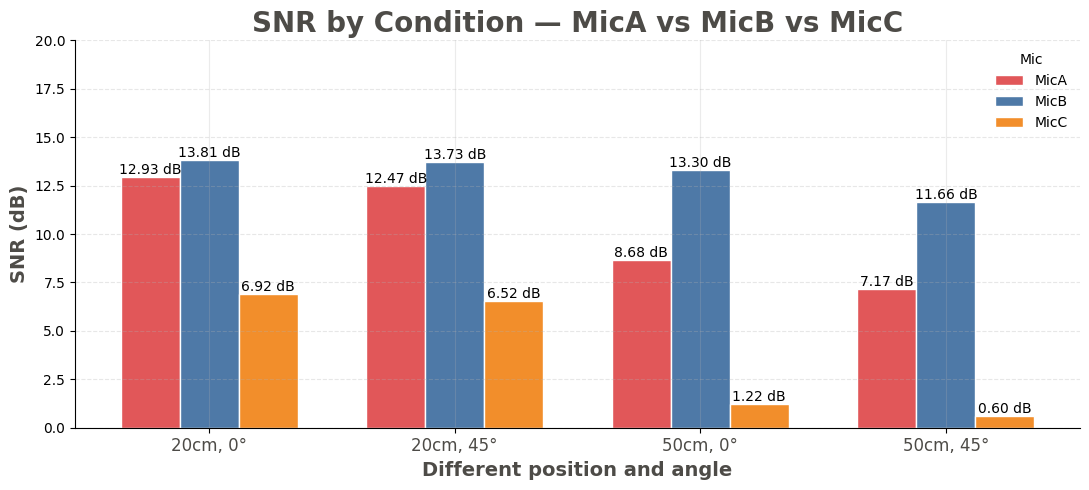

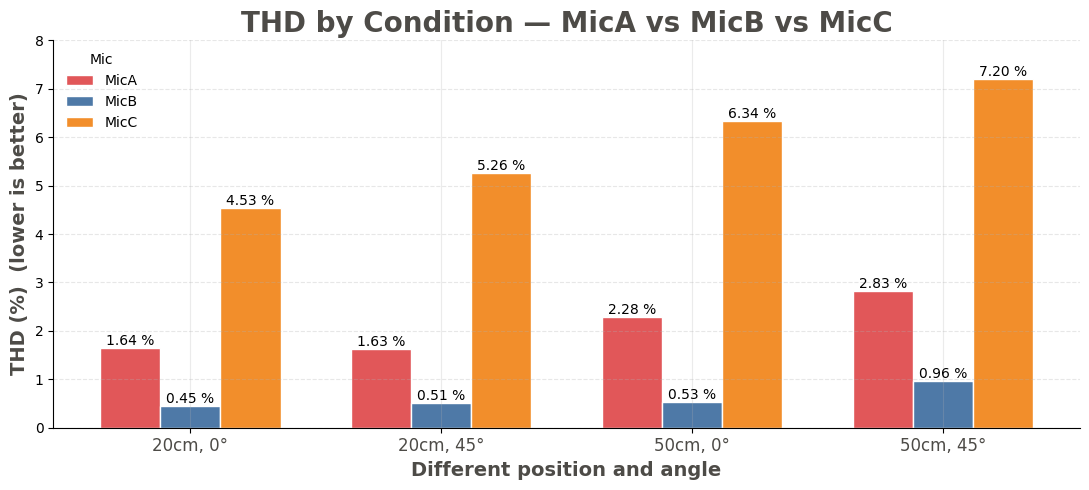

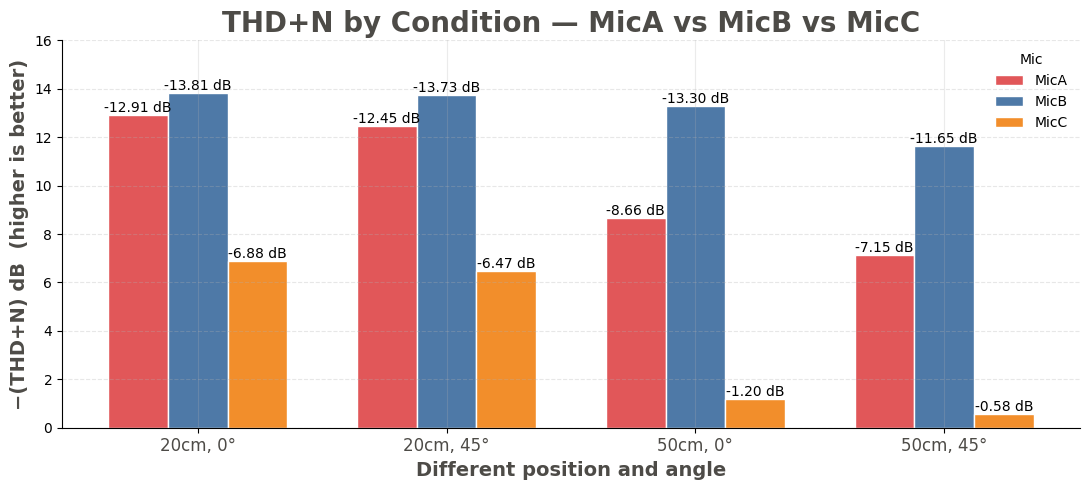

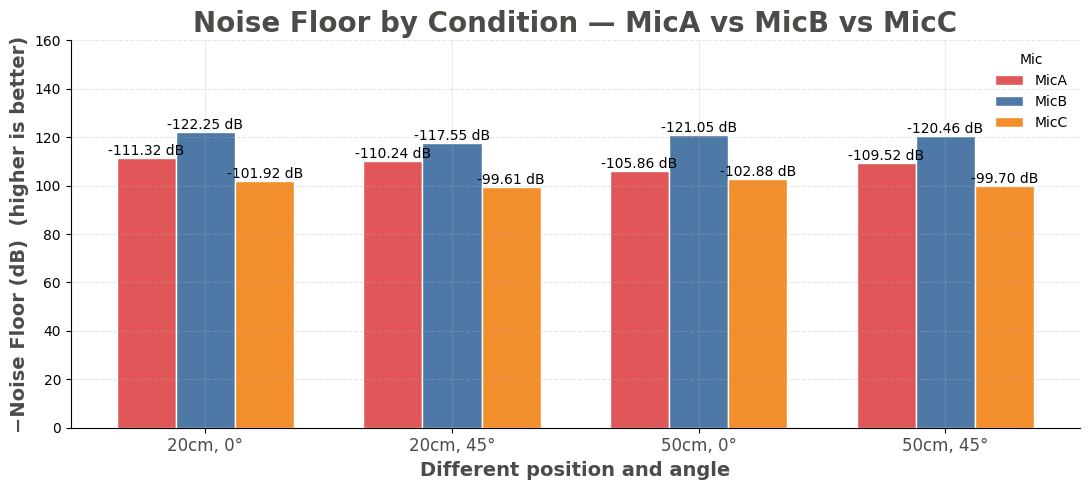

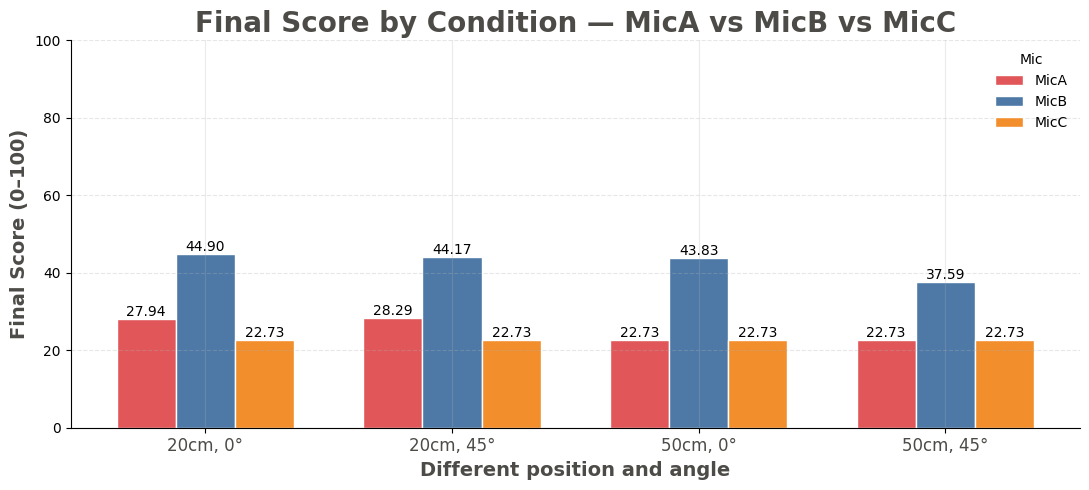

In [63]:
# 1) SNR — higher is better, y-range 0..20 as requested
grouped_bars("SNR_dB",
             ylabel="SNR (dB)",
             title="SNR by Condition — MicA vs MicB vs MicC",
             invert_for_plot=False,
             show_unit=" dB",
             ylim=(0, 20),                               # ✅ your y-range
             save_as="01_SNR_by_condition.png")

# 2) THD — lower is better (shorter bar better)
grouped_bars("THD_pct",
             ylabel="THD (%)  (lower is better)",
             title="THD by Condition — MicA vs MicB vs MicC",
             invert_for_plot=False,
             ylim=(0,8),
             show_unit=" %",
             loc="upper left",
             save_as="02_THD_by_condition.png")

# 3) THD+N — usually negative; plot as -(dB) so higher bar = better
grouped_bars("THD_N_dB",
             ylabel="−(THD+N) dB  (higher is better)",
             title="THD+N by Condition — MicA vs MicB vs MicC",
             invert_for_plot=True,
             show_unit=" dB",
             ylim=(0,16),
             save_as="03_THDN_by_condition.png")

# 4) Noise Floor — more negative is better; plot as -(dBFS)
grouped_bars("noise_floor_dbfs",
             ylabel="−Noise Floor (dB)  (higher is better)",
             title="Noise Floor by Condition — MicA vs MicB vs MicC",
             invert_for_plot=True,
             show_unit=" dB",
             ylim=(0,160),
             save_as="04_NoiseFloor_by_condition.png")

# 5) Final Score — 0..100
grouped_bars("score_final",
             ylabel="Final Score (0–100)",
             title="Final Score by Condition — MicA vs MicB vs MicC",
             invert_for_plot=False,
             ylim=(0, 100),
             save_as="05_FinalScore_by_condition.png")
